---
format: 
  html:
    toc: true
    number-sections: true
---

# Create 311 Parquet

**Do not Re-run!!**

In this section, we inspected and cleaned New York City's 311 Service Requests dataset (from 2010 to present) with 38.5 million rows. The steps include loading and converting the raw data to a master parquet tile, investigating the 311 records, filtering the dataset based on trash-related complaint type, trimming to the specific time range between 2022-01-01 and 2023-12-31, and saving the processed records. 

*This section should not be re-run due to its sole purpose for the creation of more manageable dataset.*

source: 311 Service Requests from 2010 to Present, NYC Open Data [https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9/about_data]

## Set Up

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

from datetime import datetime
import matplotlib.pyplot as plt

## Process Master Parquet File

We downloaded the 311 request dataset with 38.5 million rows from NYC Open Data, and stored it as a parquet to reduce file size and enhance usability.

In [2]:
# Create the master Parquet file
csv_file = "data/311_Service_Requests.csv"
parquet_file = "311_Service_Requests.parquet"

df = pd.read_csv(csv_file)

df['Incident Zip'] = df['Incident Zip'].astype(pd.StringDtype())

df.to_parquet('311_Service_Requests.parquet', engine='pyarrow', compression='snappy', index=False)

C:\Users\ztyuu\AppData\Local\Temp\ipykernel_35184\48896794.py:5: DtypeWarning: Columns (8,17,18,20,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)


## Trim to the Responsible Agency

All trash complaints are reported to New York Department of Sanitation (DSNY). Therefore, in this step, we trimmed the dataset to reflect only those handled by DSNY.

In [4]:
# Load the Master Parquet file
requests = pd.read_parquet('data/311_Service_Requests.parquet')

## Filter Complaints by Type

Then, we inspected all unique complaint types handled by DSNY, and used a histogram to understand major types of trash-related complaints.

In [5]:
filtered_requests = requests[
    (requests['Agency'] == 'DSNY')]

# Display unique categories in the "Complaint Type" column
complaint_types = filtered_requests['Complaint Type'].unique()

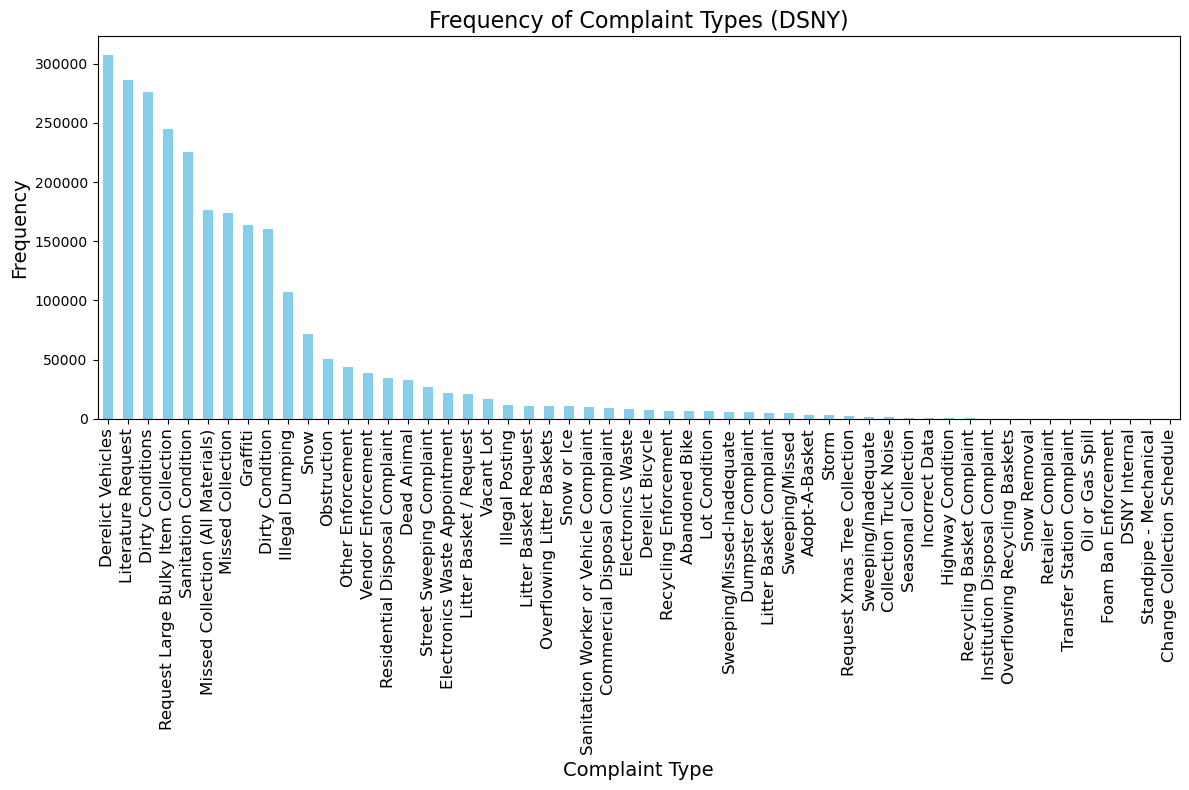

In [6]:
# Count number of complaint submitted to DSNY
complaint_counts = filtered_requests['Complaint Type'].value_counts()

# Plot histogram
plt.figure(figsize=(12, 8))
complaint_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Complaint Types (DSNY)', fontsize=16)
plt.xlabel('Complaint Type', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

## Filter Complaints by Type

Based on earlier inspections, we devised a list of complaint types representing most popular trash-removal requests. We further filtered those records from the dataset.

In [7]:
complaint_list = ['Dirty Conditions',
                  'Sanitation Condition',
                  'Dirty Condition',
                  'Illegal Dumping',
                  'Overflow Litter Baskets',
                  'Litter Basket Complaint',
                  'Dumpster Complaint',
                  'Overflowing Recycling Baskets']

# Filter for a specific complaint type and date range
complaint_filtered = filtered_requests[
    (filtered_requests['Complaint Type'].isin(complaint_list))    
]

## Filter Complaints by Time

Finally, we trimmed the range of the filtered records down to 2022-01-01 to 2023-12-31. 

In [8]:
# Create a column of the complaint creation date
complaint_filtered = complaint_filtered.rename(columns={'Created Date': 'Created Date Time'})
complaint_filtered = complaint_filtered.rename(columns={'Closed Date': 'Closed Date Time'})

complaint_filtered['Created Date'] = pd.to_datetime(complaint_filtered['Created Date Time'], format='%m/%d/%Y %I:%M:%S %p').dt.date

In [9]:
start_date = datetime.strptime('2022-01-01', '%Y-%m-%d').date()
end_date = datetime.strptime('2023-12-31', '%Y-%m-%d').date()

# Filter the dataFrame to desired time range
complaint_filtered = complaint_filtered[
    (complaint_filtered['Created Date'] >= start_date) & 
    (complaint_filtered['Created Date'] <= end_date)
]

complaint_filtered = complaint_filtered.drop(columns=['Created Date Time', 'Closed Date Time'])

## Create the Trimmed Parquet File

In [10]:
# Create the trimmed parquet file - do not re-run!!!

complaint_filtered.to_parquet('complaint_filtered.parquet', engine='pyarrow', compression='snappy', index=False)

print(f"CSV converted to Parquet")

CSV converted to Parquet
